# Homework 1

## Getting Started

 Below, I execute the code provided.

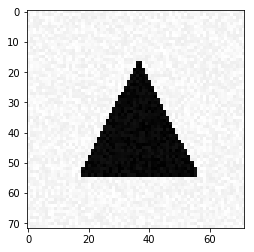

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# 1)  Simple Classification

In this part of the project, we have to create a linear classifier to classify images into three possible categories: rectangle, disk, triangle. First, we generate a training set of 300 images of simple geometric shape (three possible categories) using the function generate_dataset_classification defined above. We don't allow free location this time.

In [96]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Then , we create a classifier that will learn the parameters W and b. We load our neural network that is a simple linear classifier with 3 neurons, using softmax for output, and we choose cross-entropy as loss. By training this neural network, we will define the probability to belong to each classes.

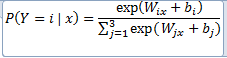

### SGD optimizer

In [97]:
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.layers import Dense, Activation 
from keras.models import Sequential 
model = Sequential()
n=3
nb_classes=3
sgd = SGD(lr=0.01,  decay=1e-6, momentum=0.9,  nesterov=True) 
Y_train_ =  np_utils.to_categorical(Y_train, nb_classes)
model.add(Dense(n, activation = 'softmax')) 
model.compile(loss = 'categorical_crossentropy', optimizer =sgd, metrics=['accuracy']) 

In [98]:
nb_epoch=20
batch_size=32
history=model.fit(X_train, Y_train_,epochs=nb_epoch,batch_size=batch_size) 

Epoch 1/20
300/300 [==============================] - 1s 4ms/step - loss: 9.4741 - acc: 0.3300
Epoch 2/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 3/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 4/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 5/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 6/20
300/300 [==============================] - 0s 147us/step - loss: 10.9066 - acc: 0.3233
Epoch 7/20
300/300 [==============================] - 0s 147us/step - loss: 10.9066 - acc: 0.3233
Epoch 8/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 9/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 10/20
300/300 [==============================] - 0s 133us/step - loss: 10.9066 - acc: 0.3233
Epoch 11/20
300/300 [=

### Adam Optimizer

Below we choose Adam optimize and we compare the convergence

In [99]:
model2 = Sequential()
nb_classes=3
model2.add(Dense(nb_classes, activation = 'softmax')) 
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(),metrics=['accuracy']) 
nb_epoch=20
batch_size=32
history2=model2.fit(X_train, Y_train_,epochs=nb_epoch,batch_size=batch_size) 

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 1.2668 - acc: 0.4767
Epoch 2/20
300/300 [==============================] - 0s 160us/step - loss: 0.5871 - acc: 0.7700
Epoch 3/20
300/300 [==============================] - 0s 133us/step - loss: 0.4392 - acc: 0.8633
Epoch 4/20
300/300 [==============================] - 0s 147us/step - loss: 0.3475 - acc: 0.9167
Epoch 5/20
300/300 [==============================] - 0s 147us/step - loss: 0.2848 - acc: 0.9700
Epoch 6/20
300/300 [==============================] - 0s 147us/step - loss: 0.2302 - acc: 0.9833
Epoch 7/20
300/300 [==============================] - 0s 160us/step - loss: 0.2010 - acc: 0.9800
Epoch 8/20
300/300 [==============================] - 0s 147us/step - loss: 0.1768 - acc: 0.9667
Epoch 9/20
300/300 [==============================] - 0s 160us/step - loss: 0.1590 - acc: 0.9800
Epoch 10/20
300/300 [==============================] - 0s 133us/step - loss: 0.1307 - acc: 0.9933
Epoch 11/20
300/300 [==========

### Comparison between SGD optimizer and Adam optimizer

we notice that with Adam optimize the loss function converges quickly.
Below we visualize the evolution of the accuracy using SGD and using Adam Optimizer. 

In [100]:
def History_Vizualization(history,stri):
    plt.subplot(121)
    plt.plot(history.history['acc'])
    try:
        plt.plot(history.history['val_acc'])
    except:
        print("No test Data")
    plt.title('model accuracy'+" "+stri)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(122)
    plt.plot(history.history['loss'])
    try:
        plt.plot(history.history['val_loss'])
    except:
        print("No test Data")
    plt.title('model loss'+" "+stri)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [107]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

The model converges

No test Data
No test Data


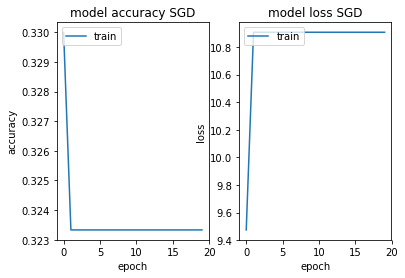

No test Data
No test Data


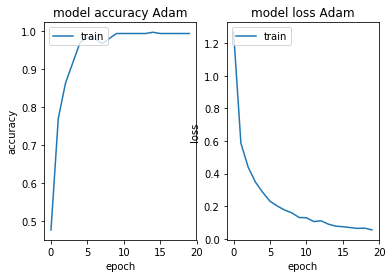

In [101]:
History_Vizualization(history,"SGD")
History_Vizualization(history2,"Adam")

 We can notice that with the SGD, the value of the loss function remains constant from the epoch 2 with a low accuracy, which shows that it stagnates around a local minimum. With Adam optimizer we can see that the model fits well the training data. With this optimizer we find a more optimal loss function and a good accuracy equal to 1. But that does not necessarily mean that the model is well in general, it will have to be evaluated on test data



# 2) Visualization of the Solution

Below, we define the function Weight_Vizualization that extracts weights of a given model and vizualize them.

In [109]:
def Weights_Vizualization(model):
    W=model.get_weights()[0]
    W1=W[:,0].reshape(72,72)
    W2=W[:,1].reshape(72,72)
    W3=W[:,2].reshape(72,72)
    fig = plt.figure(figsize=(20, 10))
    plt.subplot(131)
    plt.title("Figure 1 - Rectangle")
    plt.imshow(W1)
    plt.subplot(132)
    plt.title("Figure 2 - Disk")
    plt.imshow(W2)
    plt.subplot(133)
    plt.title("Figure 3 - triangle")
    plt.imshow(W3)
    plt.show()

 We notice that we can recognize the different shapes.

*************************************************
-------------------------------------------------
*********** Weights - Adam Optimizer***********
-------------------------------------------------
*************************************************


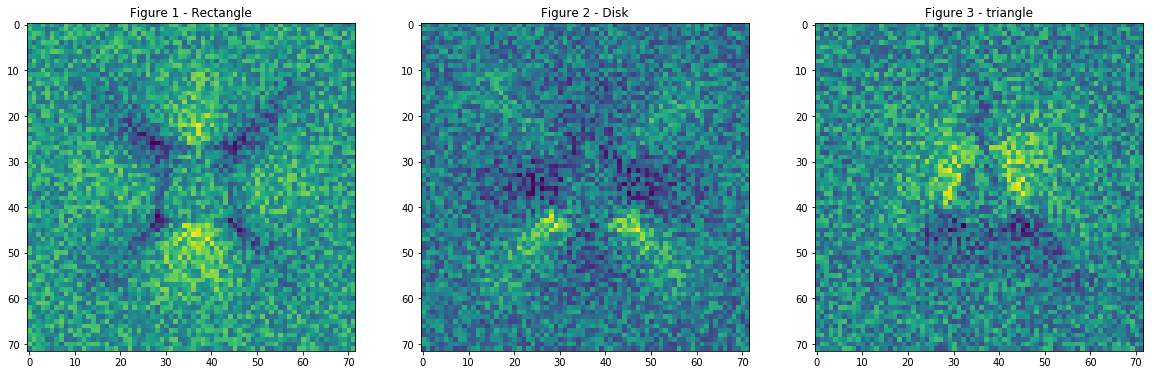

*************************************************
-------------------------------------------------
-------------Weights - SGD Optimizer -------------
--------------------------------------------------
*************************************************


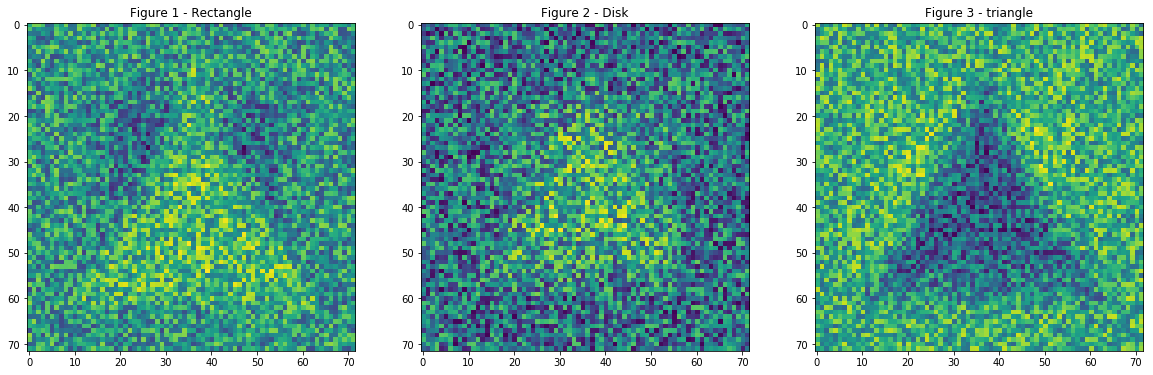

In [110]:
print("*************************************************")
print("-------------------------------------------------")
print("*********** Weights - Adam Optimizer***********")
print("-------------------------------------------------")
print("*************************************************")
Weights_Vizualization(model2)
print("*************************************************")
print("-------------------------------------------------")
print("-------------Weights - SGD Optimizer -------------")
print("--------------------------------------------------")
print("*************************************************")
Weights_Vizualization(model)

 We see a different shape in each figure. The figure 1 is the filter that detects rectangles, figure 2 has to detect disks and figure 3 detects triangles. We can see that filters of the model with Adam Optimizer are clearer.

# 3) A More Difficult Classification Problem


 In this part, the shapes are allowed to move within the images and change dimensions. In other words, we choose the argument free_location=True when we generate the new training dataset. 

In [111]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


Then, we generate the test set using generate_test_set_classification() function. The shapes generated with this function are also allowed to move within the images and change dimensions.

In [112]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


 First, we retrain the linear classifier (with Adam Optimizer)  on this new training set.

In [113]:
model3 = Sequential()
Y_train_ =  np_utils.to_categorical(Y_train, nb_classes)
model3.add(Dense(nb_classes, activation = 'softmax')) 
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(),metrics=['accuracy'],validation_data=(X_test,Y_test)) 
nb_epoch=50
batch_size=32
history3=model3.fit(X_train, Y_train_,epochs=nb_epoch,batch_size=batch_size,validation_data=(X_test,Y_test)) 

Train on 500 samples, validate on 300 samples
Epoch 1/50
500/500 [==============================] - 1s 3ms/step - loss: 1.8093 - acc: 0.3720 - val_loss: 1.0208 - val_acc: 0.4300
Epoch 2/50
500/500 [==============================] - 0s 272us/step - loss: 1.1331 - acc: 0.4000 - val_loss: 1.1703 - val_acc: 0.5333
Epoch 3/50
500/500 [==============================] - 0s 184us/step - loss: 1.0032 - acc: 0.5060 - val_loss: 1.0672 - val_acc: 0.4867
Epoch 4/50
500/500 [==============================] - 0s 192us/step - loss: 0.9472 - acc: 0.4840 - val_loss: 0.9521 - val_acc: 0.4900
Epoch 5/50
500/500 [==============================] - 0s 184us/step - loss: 0.8555 - acc: 0.6020 - val_loss: 0.8875 - val_acc: 0.5333
Epoch 6/50
500/500 [==============================] - 0s 184us/step - loss: 0.8004 - acc: 0.6080 - val_loss: 0.8412 - val_acc: 0.5667
Epoch 7/50
500/500 [==============================] - 0s 200us/step - loss: 0.8303 - acc: 0.6200 - val_loss: 0.8538 - val_acc: 0.5867
Epoch 8/50
500/500

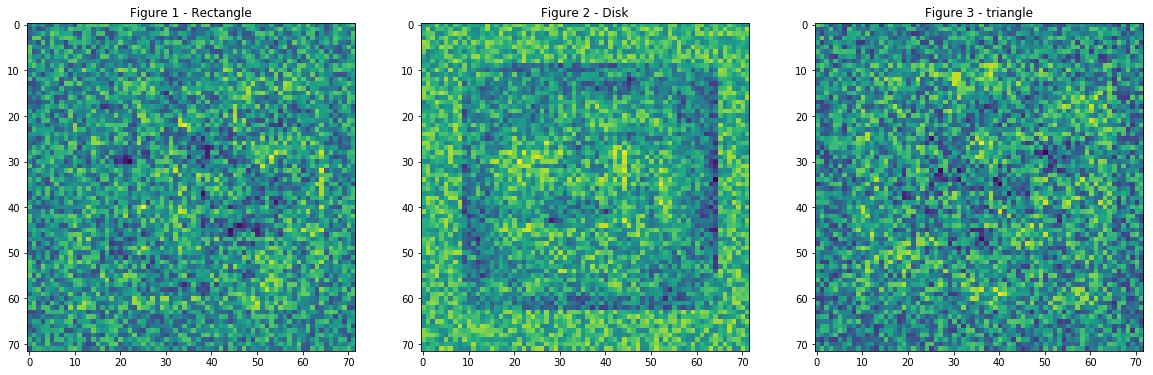

In [114]:
Weights_Vizualization(model3)


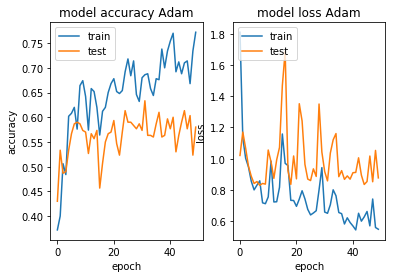

In [115]:
History_Vizualization(history3,"Adam")

This simple model doesn't  fit well the training data and the test data because of changing shapes and positions. That's why We will try convolutional deep network.

As suggested in the statement, I used  as a first step 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer. Then, I reshape the input data to be adequate with CNN. We use relu activation function with hidden layers and softmax activation function with the output layer as it is a classification problem. Below the code:

In [139]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True) #Improve nb of data to improve the score
[X_test, Y_test] = generate_test_set_classification()
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [140]:
X_train=X_train.reshape(300,72,72,1)
X_test=X_test.reshape(300,72,72,1)

In [141]:
Y_train = np_utils.to_categorical(Y_train)

In [142]:
model.compile(loss ='categorical_crossentropy', optimizer =Adam(),metrics=['accuracy'])
history4=model.fit(X_train, Y_train,epochs=40, batch_size=32,validation_data = (X_test, Y_test))

Train on 300 samples, validate on 300 samples
Epoch 1/40
300/300 [==============================] - 6s 22ms/step - loss: 1.1215 - acc: 0.4233 - val_loss: 1.0653 - val_acc: 0.5200
Epoch 2/40
300/300 [==============================] - 5s 16ms/step - loss: 0.9809 - acc: 0.6100 - val_loss: 0.9735 - val_acc: 0.5267
Epoch 3/40
300/300 [==============================] - 5s 16ms/step - loss: 0.8343 - acc: 0.6200 - val_loss: 0.8119 - val_acc: 0.6767
Epoch 4/40
300/300 [==============================] - 5s 16ms/step - loss: 0.6945 - acc: 0.7267 - val_loss: 0.7365 - val_acc: 0.6867
Epoch 5/40
300/300 [==============================] - 5s 16ms/step - loss: 0.5929 - acc: 0.7700 - val_loss: 0.6949 - val_acc: 0.7033
Epoch 6/40
300/300 [==============================] - 5s 17ms/step - loss: 0.4971 - acc: 0.8000 - val_loss: 0.6794 - val_acc: 0.6967
Epoch 7/40
300/300 [==============================] - 5s 17ms/step - loss: 0.4323 - acc: 0.8333 - val_loss: 0.6211 - val_acc: 0.7367
Epoch 8/40
300/300 [===

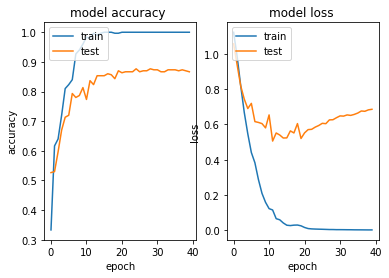

In [26]:
History_Vizualization(history4,"")

The model converges, and We had got very good results, a loss of 0.0037 and an accuracy equal to 1.

# 4)  A Regression Problem

For this regression problem, we have to predict the coordinates of the vertices of dataset. First, we generate the training data set. I chose to use 5000 samples.

In [147]:
[X_train5, Y_train5] = generate_dataset_regression(5000, 20)
[X_test5, Y_test5] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

To make the task less difficult for the network, we can sort the vertices of triangles, because they are given in a random and it is difficult for the network to recognize the order of each triangle's vertices. For this, we use the function normalize below:

In [148]:
def normalize(Y_train):
    Y_train_normalized = np.zeros(Y_train.shape)
    Y_order = np.argsort(Y_train[:,::2], axis=1)

    for i in range(Y_train.shape[0]):
        Y_train_normalized[i, ::2] = Y_train[i, Y_order[i]*2]
        Y_train_normalized[i, 1::2] = Y_train[i, Y_order[i]*2 + 1]
    return Y_train_normalized

Y_train_normalized=normalize(Y_train5)
Y_test_normalized =normalize(Y_test5)

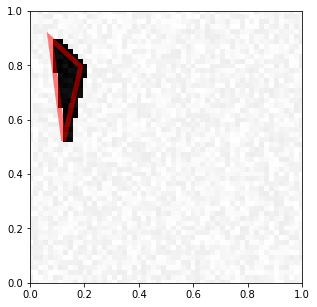

In [149]:
visualize_prediction(X_train5[1], Y_train5[1])

Since the problem is complicated, and to get good results, we use a deep neural network with convolutional layers and MaxPoolings

In [152]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,AveragePooling2D, Flatten, Dropout,Dense
from keras.models import Sequential 

model5 = Sequential()
model5.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)))
model5.add(MaxPooling2D((2,2), strides=2))
model5.add(Conv2D(30, (4, 4), activation='relu',))
model5.add(MaxPooling2D((2,2), strides=2))
model5.add(Conv2D(64, (5, 5), activation='relu'))
model5.add(Flatten())
model5.add(Dense(140, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(100, activation='relu'))
model5.add(Dense(6, activation='sigmoid'))
model5.compile(optimizer='adam', loss="mean_squared_error",metrics=['accuracy'])

In [153]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 31, 31, 30)        7710      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 15, 15, 30)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 11, 11, 64)        48064     
_________________________________________________________________
flatten_13 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 140)               1084300   
__________

In [154]:
X_train5=X_train5.reshape(-1,72,72,1)
X_test5=X_test5.reshape(-1,72,72,1)

In [155]:
history5 = model5.fit(X_train5, Y_train_normalized, validation_split=0.2, epochs=50, batch_size=300)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 34s 8ms/step - loss: 0.0683 - acc: 0.4140 - val_loss: 0.0547 - val_acc: 0.4890
Epoch 2/50
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0477 - acc: 0.5170 - val_loss: 0.0334 - val_acc: 0.5850
Epoch 3/50
4000/4000 [==============================] - 33s 8ms/step - loss: 0.0354 - acc: 0.5725 - val_loss: 0.0262 - val_acc: 0.6110
Epoch 4/50
4000/4000 [==============================] - 30s 8ms/step - loss: 0.0297 - acc: 0.6060 - val_loss: 0.0221 - val_acc: 0.6500
Epoch 5/50
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0263 - acc: 0.6270 - val_loss: 0.0195 - val_acc: 0.6680
Epoch 6/50
4000/4000 [==============================] - 30s 8ms/step - loss: 0.0239 - acc: 0.6498 - val_loss: 0.0178 - val_acc: 0.6940
Epoch 7/50
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0215 - acc: 0.6595 - val_loss: 0.0148 - val_acc: 0.7110
Epoch 8

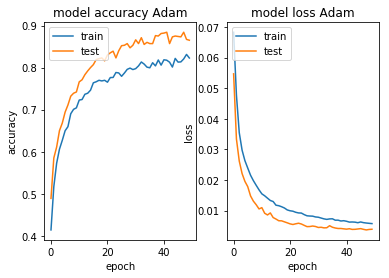

In [156]:
History_Vizualization(history5,"Adam")

We can see that the model fits well the training data and validation data. We have an accuracy of 0.86 and a loss function equal to 0.0039.

In [157]:
preds5 = model5.predict(X_test5)


Below we test the model:

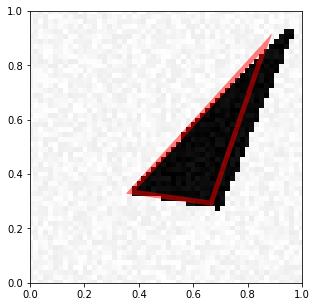

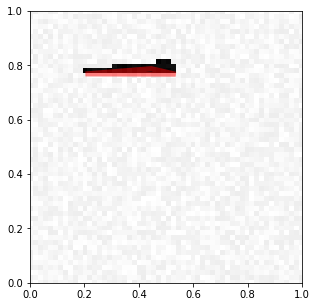

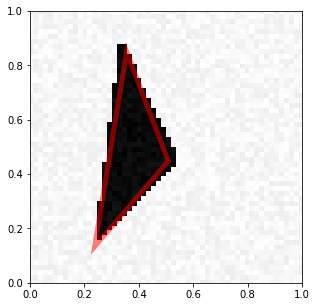

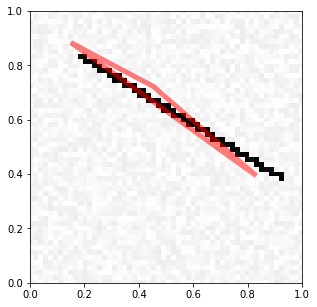

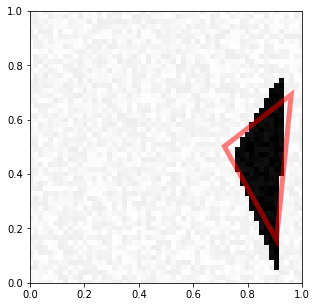

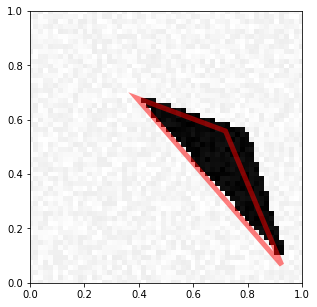

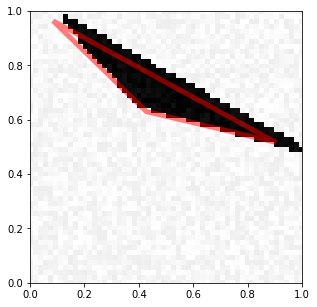

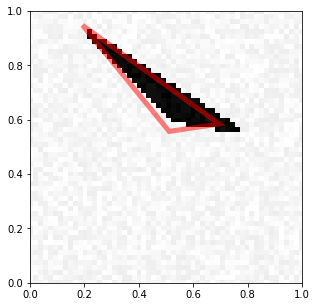

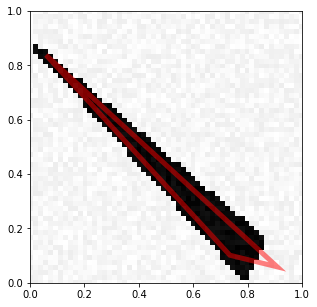

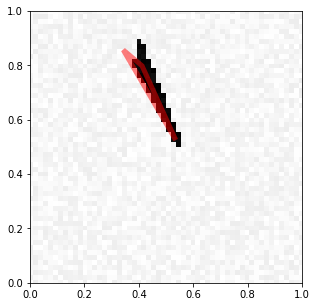

In [158]:
for i in range(10):
    visualize_prediction(X_test5[i], preds5[i])

# Image Denoising

 I modified the generate_a_* functions to generate pairs of images, where one image has noise with random amplitude  between 10 and 40. 


In [160]:
def generate_a_drawing2(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return(imdata_noise,imdata)

def generate_a_rectangle2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return(generate_a_drawing2(figsize, U, V, noise))


def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return(generate_a_drawing2(figsize, U, V, noise))

def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3).reshape((1,-1))
        V = np.random.random(3).reshape((1,-1))
        
        ##sort vertices by increasing x in order to improve the regression outcomes
        vertices = np.concatenate((U,V),axis=0)
        vertices = vertices[:,vertices[0,:].argsort()]
        U = vertices[0]
        V = vertices[1]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing2(figsize, U, V, noise)
    return([imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]])


def generate_dataset_noise2(nb_samples, free_location=False):
    # Getting im_size:
    im_size = (generate_a_rectangle2()[0]).shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.randint(10,30)
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i],Y[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1: 
            X[i],Y[i] = generate_a_disk2(noise, free_location)
        else:
            output = generate_a_triangle2(noise, free_location)
            X[i],Y[i] = output[0]
    X = (X) / (255)
    Y = (Y)/(255)
    return([X, Y])


def generate_test_set_noise2():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_noise2(300)
    return([X_test, Y_test])    

We can see the probleme as a segmentation task. As we have seen in class, hourglass network are mainly used for segmentation. We want to decide whether a pixel is black or white. Hence, we add a sigmoid layer. Here is the Model. We train it on 900 samples and validate it on 100 samples.

## Hourglass network

In [161]:
from keras.models import Model

inputImage= Input(shape=(72,72,1))

Layer = Conv2D(32, (3, 3), activation='relu', padding='same')(inputImage)
encoder = MaxPooling2D((2, 2))(Layer)
Layer = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
Layer = UpSampling2D((2, 2))(Layer)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(Layer)
modeld = Model(inputImage, decoder)
modeld.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

We generate training data

In [164]:
[X_traind, Y_traind] =  generate_dataset_noise2(1000)
[X_testd, Y_testd] = generate_test_set_noise2()

X_traind = X_traind.reshape(-1, 72, 72, 1)
X_testd = X_testd.reshape(-1, 72, 72, 1)

Y_traind = Y_traind.reshape(-1, 72, 72, 1)
Y_testd = Y_testd.reshape(-1, 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [170]:
historyd = modeld.fit(X_traind, Y_traind, epochs=50,batch_size=100,validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 14s 16ms/step - loss: 0.4974 - acc: 0.7933 - val_loss: 0.3652 - val_acc: 0.7584
Epoch 2/50
900/900 [==============================] - 13s 15ms/step - loss: 0.2895 - acc: 0.7863 - val_loss: 0.2692 - val_acc: 0.7609
Epoch 3/50
900/900 [==============================] - 13s 15ms/step - loss: 0.2239 - acc: 0.8608 - val_loss: 0.2027 - val_acc: 0.9485
Epoch 4/50
900/900 [==============================] - 13s 15ms/step - loss: 0.1551 - acc: 0.9652 - val_loss: 0.1242 - val_acc: 0.9749
Epoch 5/50
900/900 [==============================] - 13s 15ms/step - loss: 0.0848 - acc: 0.9821 - val_loss: 0.0580 - val_acc: 0.9950
Epoch 6/50
900/900 [==============================] - 14s 16ms/step - loss: 0.0390 - acc: 0.9968 - val_loss: 0.0272 - val_acc: 0.9970
Epoch 7/50
900/900 [==============================] - 14s 15ms/step - loss: 0.0202 - acc: 0.9978 - val_loss: 0.0163 - val_acc: 0.9980
Epoch 8/50
900/9

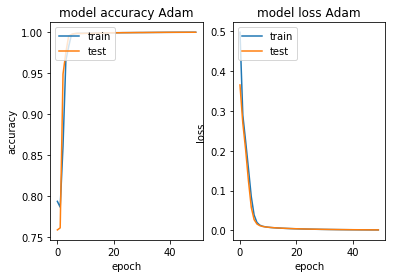

In [171]:
History_Vizualization(historyd,"Adam")

Our model fits well training data and validation data with an accuracy of 0.9997

In [172]:
predictions=modeld.predict(X_testd) 

Text(0.5, 1.0, 'Input train denoising')

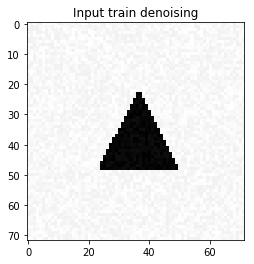

In [173]:
plt.imshow(X_train[0].reshape(72,72), cmap='gray')
plt.title('Input train denoising')

Text(0.5, 1.0, 'Output train denoising')

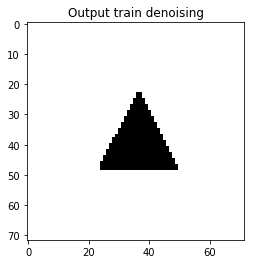

In [174]:
plt.imshow(Y_train[0].reshape(72,72), cmap='gray')
plt.title('Output train denoising')


Below we visualize predictions of the model:

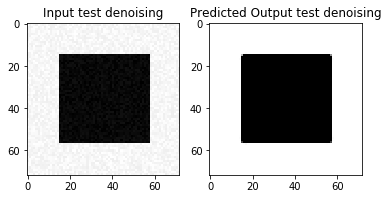

In [181]:
plt.subplot(121)
plt.title("Input test denoising")
plt.imshow(X_testd[0].reshape(72,72), cmap='gray')
plt.subplot(122)
plt.title("Predicted Output test denoising")
plt.imshow(predictions[0].reshape(72,72), cmap='gray')

 

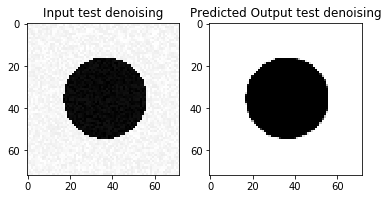

In [182]:
plt.subplot(121)
plt.title("Input test denoising")
plt.imshow(X_testd[36].reshape(72,72), cmap='gray')
plt.subplot(122)
plt.title("Predicted Output test denoising")
plt.imshow(predictions[36].reshape(72,72), cmap='gray')

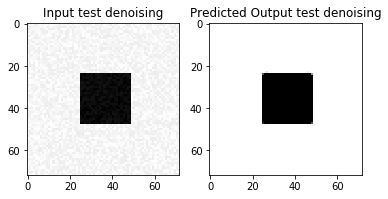

In [183]:
plt.subplot(121)
plt.title("Input test denoising")
plt.imshow(X_testd[100].reshape(72,72), cmap='gray')
plt.subplot(122)
plt.title("Predicted Output test denoising")
plt.imshow(predictions[100].reshape(72,72), cmap='gray')

We can see that we have good results.